In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from skmultilearn.adapt import MLkNN
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
     
from nltk.stem.snowball import SnowballStemmer

import pandas as pd
import json
import os
import re

import gensim 
from gensim.models import Word2Vec
import gensim.downloader

import pickle 

import nltk
from nltk.tokenize import word_tokenize

import spacy
import matplotlib
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
from ast import literal_eval
from tqdm import tqdm

import sklearn.metrics
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /homes/lgf21/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
tqdm.pandas()

In [30]:
#cp ../src/rcatt_training_data_original.csv .

# Opening Files: 

In [1]:
rcatt_data = '../src/rcatt_training_data_original.csv'
scraped_data = '../src/training_dataset_full.csv'

In [2]:
# transform into dataframes: 

df_r = pd.read_csv(rcatt_data).reset_index(drop = True)
df_r = df_r[~df_r['Text'].duplicated()]
df_s = pd.read_csv(scraped_data).reset_index(drop = True).rename(columns={'text': 'Text'})

NameError: name 'pd' is not defined

In [6]:
# Converting from string to list using literal_eval:

for col in ['mitre_domain', 'tech_name', 'tech_id', 'tactic_id', 'software_id']:
    df_s[col] = df_s[col].apply(literal_eval)

# Merging Files: 

In [7]:
mlb = MultiLabelBinarizer()
Y_s = mlb.fit_transform(df_s['tactic_id'])
Y_s = pd.DataFrame(Y_s, columns=mlb.classes_)

In [8]:
X_r = df_r['Text']
Y_r = df_r[[col for col in df_r.columns if col.startswith('TA')]]

In [9]:
Y1 = Y_s[Y_r.columns]
Y_s = Y1[Y1.sum(axis=1)>0] 
X_s = df_s['Text']
X_s = X_s[Y1.sum(axis=1)>0] # all urls who map at least one of the tactic in Y1

# Pre-processing: 

In [9]:
# Open Pickle: 

with open('lemma_preprocessing.pickle', 'rb') as handle:
    tac_preprocessing = pickle.load(handle)

In [134]:
np.mean(list(map(len, X_r))) # length of text - average 21,542 words 

21542.208588957055

In [10]:
nlp = spacy.load("en_core_web_sm", disable=['ner']) 

In [11]:
# Lemmatisation: 

df = pd.DataFrame({"text": X_r})
df['lemma'] = df['text'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))


In [100]:
# Stemming: 

#stemmer = SnowballStemmer(language='english')
#df['stemmer'] = df['text'].apply(lambda x: " ".join([stemmer.stem(token) for token in x]))


In [138]:
# Save as pickle: 

with open('lemma_preprocessing.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Split dataset: 

In [12]:
# change x train to df['lemma'] or X_r #


X_r_train, X_test_text, Y_r_train, Y_test = train_test_split(df['lemma'], Y_r, test_size=0.3,
                                                    random_state = 10)

In [13]:
X_train_text = pd.concat([X_r_train, X_s])

In [14]:
Y_train = pd.concat([Y_r_train, Y_s]).reset_index(drop=True)

# Feature Extraction:

In [19]:
def feature_extraction(featureExtract, X_train_text, X_test_text, average = False, embedding_type = None):
    if featureExtract in ['CountVectorizer', 'TfIdfVectorizer']:
        if featureExtract == 'CountVectorizer':
            fe = CountVectorizer(analyzer ='word', stop_words ='english', lowercase = True, min_df = 2, max_df = 0.99) # if words used less than 0.001 % and in less than 2 documents --> ignore  
        else:
            fe = TfidfVectorizer(analyzer = 'word', stop_words='english', lowercase=True, min_df = 2, max_df=0.99)
        
        X_train = fe.fit_transform(X_train_text)
        X_train = pd.DataFrame(X_train.toarray(), columns = fe.get_feature_names()) 
        X_test = fe.transform(X_test_text)
        X_test = pd.DataFrame(X_test.toarray(), columns = fe.get_feature_names())
    
    else:
        if embedding_type is None:
            raise ValueError("Missing embedding method")
        model = embedding_type
        # sent is tokenised sentence on which we do the embedding
        def get_embeddings(sent):
            # if text not in vocab:
            words_in_vocab = [word for word in sent if word in model]
            if not words_in_vocab:
                return np.zeros_like(model['the'])
            emb = model[words_in_vocab]
            return np.mean(emb, axis=0) if average else np.sum(emb, axis=0)
        #perform tokenisation
        X_train = pd.DataFrame(X_train_text.progress_apply(nltk.word_tokenize).progress_apply(get_embeddings).values.tolist())
        X_test = pd.DataFrame(X_test_text.progress_apply(nltk.word_tokenize).progress_apply(get_embeddings).values.tolist())
    return X_train, X_test
        
        
        

In [14]:
#X_train, X_test = feature_extraction('CountVectorizer', X_train_text, X_test_text)

/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
#X_train, X_test = feature_extraction('TfIdfVectorizer', X_train_text, X_test_text)

/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [49]:
#X_train, X_test = feature_extraction('word2vec-google-news-300', X_train_text, X_test_text)

[--------------------------------------------------] 1.4% 23.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==------------------------------------------------] 4.1% 68.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====----------------------------------------------] 8.4% 139.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 11.2% 186.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======--------------------------------------------] 14.0% 232.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========------------------------------------------] 16.8% 278.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========-----------------------------------------] 19.5% 324.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 22.1% 367.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============-------------------------------------] 26.4% 438.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 31.1% 516.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 35.0% 582.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================-------------------------------] 39.2% 652.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 44.0% 731.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 47.5% 790.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================------------------------] 52.2% 868.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================----------------------] 56.2% 934.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 58.9% 979.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 61.7% 1025.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 63.7% 1059.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================------------------] 65.9% 1096.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 68.3% 1136.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================================---------------] 70.9% 1179.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================================--------------] 73.6% 1223.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================================------------] 76.1% 1265.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================================-----------] 78.7% 1308.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================================----------] 81.4% 1353.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================================--------] 84.1% 1398.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================================-------] 86.8% 1443.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================================------] 89.4% 1487.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================================----] 93.4% 1552.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================================-] 98.1% 1631.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 1662.8/1662.8MB downloaded


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:02<00:00, 214.70it/s]


In [18]:
# ---------------- Word2Vec ---------------------: 

#glove = gensim.downloader.load('glove-wiki-gigaword-100')


In [ ]:
# ---------------- Glove ---------------------: 

# load the whole embedding into memory
#embeddings_index = dict()
#f = open('../data/glove/glove.6B.100d.txt')

# loop through each lines as key, values as coefficients
#for line in f:
#    values = line.split()
#    word = values[0]
#    coefs = np.asarray(values[1:], dtype='float32')
#    embeddings_index[word] = coefs 

#f.close()

#X_train = df['lemma'].apply(lambda x: [embeddings_index[word] for word in x]) 


In [ ]:
#glv = gensim.downloader('glove-wiki-gigaword-100')

In [216]:
#X_train, X_test = feature_extraction('embedding', X_train_text, X_test_text, embedding_type = glv)

100%|██████████| 441/441 [00:04<00:00, 88.96it/s] 


In [20]:
w2v = Word2Vec.load("word2vec.model").wv

In [22]:
X_train, X_test = feature_extraction("embedding", X_train_text, X_test_text, embedding_type = w2v)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:02<00:00, 157.22it/s]


# Measuring Cosine Similarity to Remove Duplicates: 

In [23]:
similarities = cosine_similarity(X_train, X_test)

In [24]:
duplicates = set()
for i in range(similarities.shape[0]):
    for j in range(similarities.shape[1]):
        if similarities[i][j] > 0.9:
            # print(i, j, similarities[i][j])
            duplicates.add(i)

In [25]:
X_train_text = X_train_text[~X_train_text.index.isin(duplicates)]
X_train = X_train[~X_train.index.isin(duplicates)]
Y_train = Y_train[~Y_train.index.isin(duplicates)]

# Visualisation:

<AxesSubplot:>

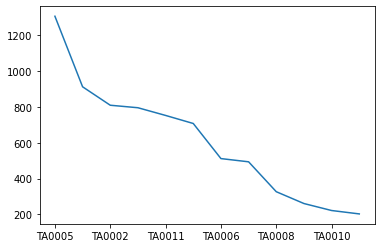

In [20]:
Y_train.sum(axis=0).sort_values(ascending=False).plot()

<AxesSubplot:>

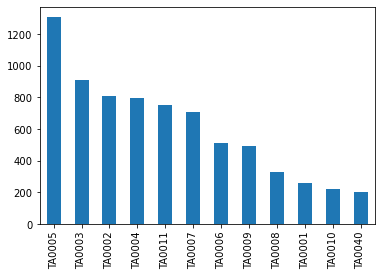

In [21]:
Y_train.sum(axis=0).sort_values(ascending=False).plot(kind='bar')

In [288]:
# TSNE using vector from glove: 

X = list(X_train.values)
X_embedded = TSNE(n_components=2).fit_transform(X)

df_embeddings = pd.DataFrame(X_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label= Y_train)

ValueError: Expected a 1D array, got an array with shape (2229, 12)

In [ ]:
fig = px.scatter(
    df_embeddings, x ='tactic', y ='text',
    color='label', labels={'color': 'label'}
    hover_data=['text'], title = 'GoEmotions Embedding Visualization')
fig.show()

# Evaluation:

In [26]:
def evaluation(Y_pred, Y_test):
    macro_precision = precision_score(Y_test, Y_pred, average ='macro')
    micro_precision = precision_score(Y_test, Y_pred, average ='micro')
    macro_recall = recall_score(Y_test, Y_pred, average='macro')
    micro_recall = recall_score(Y_test, Y_pred, average='micro')
    macro_fscore = fbeta_score(Y_test, Y_pred, beta=0.5, average ='macro')
    micro_fscore = fbeta_score(Y_test, Y_pred, beta=0.5, average ='micro')
    l_metric = ['macro precision', 'micro precision', 'macro recall', 'micro recall', 'macro fscore', 'micro fscore']
    l_result = [macro_precision, micro_precision, macro_recall, micro_recall, macro_fscore, micro_fscore]
    df_res = pd.DataFrame({'metric': l_metric, 'result': l_result})
    return df_res

## Naive Bayes:

In [27]:
naive_bayes_classifier = OneVsRestClassifier(MultinomialNB())
naive_bayes_classifier.fit(X_train, Y_train)

ValueError: Negative values in data passed to MultinomialNB (input X)

In [81]:
y_pred_proba = pd.DataFrame(naive_bayes_classifier.predict_proba(X_test), columns = Y_test.columns)

In [82]:
y_pred = (y_pred_proba > 0.005).astype(int) # if increase threshold, recall decreases and precision (could) increase

In [83]:
evaluation(y_pred, Y_test)

,metric,result
0,macro precision,0.666805
1,micro precision,0.423497
2,macro recall,0.306688
3,micro recall,0.253475
4,macro fscore,0.382681
5,micro fscore,0.373404


## SVC:

In [28]:
# Train and test: First delete techniques less than 9 
# We fix the random state to have the same dataset in our different tests

sv_classifier = OneVsRestClassifier(LinearSVC(penalty = 'l2', loss = 'squared_hinge', dual = False, max_iter = 1000, class_weight = 'balanced', random_state=42), n_jobs = 1)
sv_classifier.fit(X_train, Y_train)


/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/s

OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced', dual=False,
                                        random_state=42),
                    n_jobs=1)

In [29]:
Y_pred = pd.DataFrame(sv_classifier.predict(X_test), columns=Y_test.columns)

In [30]:
evaluation(Y_pred, Y_test)

,metric,result
0,macro precision,0.212233
1,micro precision,0.317778
2,macro recall,0.252243
3,micro recall,0.350777
4,macro fscore,0.202236
5,micro fscore,0.323871


## Multi-label KNN: 

In [31]:
knn = MLkNN(k = 3)

In [32]:
# train
knn.fit(X_train.values, Y_train.values)

# predict
predictions = knn.predict(X_test.values)

TypeError: __init__() takes 1 positional argument but 2 were given

In [33]:
evaluation(predictions, Y_test)

NameError: name 'predictions' is not defined

## Logistic Regression:

In [ ]:
# reduce dimension using pca: 

pca = PCA(n_components=150)
pca.fit(X_train)
pca_result = pca.transform(X_train)
x_test_result = pca.transform(X_test )

In [ ]:
X_train.shape

In [ ]:
log_reg = OneVsRestClassifier(LogisticRegression(random_state=0, multi_class='multinomial', solver='lbfgs', max_iter = 1000)).fit(X_train, Y_train)

predictions = log_reg.predict(X_test)


In [ ]:
evaluation(predictions, Y_test)

## DT AdaBoost: 

In [71]:
dt_adaboost = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=0)).fit(X_train, Y_train)
predictions_ada = dt_adaboost.predict(X_test)

KeyboardInterrupt: 

In [ ]:
evaluation(predictions_ada, Y_test)

# Classifer Chain: 

In [ ]:
def chain_model(model):
    model_chain = ClassifierChain(model, order='random', random_state=0)
    return model_chain

In [89]:
#chain = chain_model(naive_bayes_classifier) # change model appropriately

In [ ]:
chain = chain_model(log_reg) # change model appropriately

In [ ]:
chainModel = chain.fit(X_train.values, Y_train.values)
predictions = chainModel.predict(X_test.values)

In [ ]:
evaluation(predictions, Y_test)

# Neural Networks:

## Multi Layer Perceptron: 

In [43]:
mlp = MLPClassifier(random_state=1, max_iter=300).fit(X_train, Y_train)

In [44]:
predictions_mlp = mlp.predict(X_test)

In [48]:
evaluation(predictions_mlp, Y_test)

,metric,result
0,macro precision,0.715035
1,micro precision,0.728484
2,macro recall,0.526173
3,micro recall,0.581357
4,macro fscore,0.658048
5,micro fscore,0.693388


## Transformers:

In [23]:
with open('fasttext_format_test.txt', 'w') as file:
    for i in range(len(Y_test)):
        file.write(' '.join(['__label__'+col for col in Y_test.columns if Y_test.iloc[i][col] == 1]) + ' ' + X_test_text.iloc[i] + '\n')

In [24]:
from flair.data import Corpus
from flair.datasets import ClassificationCorpus

# this is the folder in which train, test and dev files reside
data_folder = '.'

# load corpus containing training, test and dev data
corpus = ClassificationCorpus(data_folder,
                                      test_file='fasttext_format_test.txt',
                                      dev_file='fasttext_format_test.txt',
                                      train_file='fasttext_format_train.txt',
                                      label_type='tactic',
                                      )

2022-07-20 12:16:45,855 Reading data from .
2022-07-20 12:16:45,856 Train: fasttext_format_train.txt
2022-07-20 12:16:45,857 Dev: fasttext_format_test.txt
2022-07-20 12:16:45,859 Test: fasttext_format_test.txt
2022-07-20 12:16:47,165 Initialized corpus . (label type name is 'tactic')


In [25]:
# 2. what label do we want to predict?
label_type = 'tactic'

# 3. create the label dictionary
label_dict = corpus.make_label_dictionary(label_type=label_type)

2022-07-20 12:16:47,168 Computing label dictionary. Progress:


2152it [02:23, 14.97it/s]

2022-07-20 12:19:11,181 Dictionary created for label 'tactic' with 13 values: TA0005 (seen 1237 times), TA0003 (seen 857 times), TA0002 (seen 756 times), TA0004 (seen 742 times), TA0011 (seen 688 times), TA0007 (seen 659 times), TA0006 (seen 487 times), TA0009 (seen 465 times), TA0008 (seen 312 times), TA0001 (seen 248 times), TA0010 (seen 199 times), TA0040 (seen 190 times)


In [26]:
from flair.embeddings import TransformerDocumentEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
import flair
flair.device = 'cpu'


# initialize transformer document embeddings (many models are available)
document_embeddings = TransformerDocumentEmbeddings('binay1999/text_classification_cybertexts', fine_tune=True)

# create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, label_type=label_type, multi_label=True)

# initialize trainer
trainer = ModelTrainer(classifier, corpus)

# run training with fine-tuning
trainer.fine_tune('test_model',
                  learning_rate=5.0e-5,
                  mini_batch_size=4,
                  max_epochs=10,
                  )

2022-07-20 12:19:19,202 ----------------------------------------------------------------------------------------------------
2022-07-20 12:19:19,203 Model: "TextClassifier(
  (decoder): Linear(in_features=768, out_features=13, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): BCEWithLogitsLoss()
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_feat

2022-07-20 12:33:29,490 epoch 1 - iter 265/538 - loss 0.13957457 - samples/sec: 1.35 - lr: 0.000025
2022-07-20 12:36:13,063 epoch 1 - iter 318/538 - loss 0.13106347 - samples/sec: 1.36 - lr: 0.000030
2022-07-20 12:38:54,013 epoch 1 - iter 371/538 - loss 0.12337013 - samples/sec: 1.37 - lr: 0.000034
2022-07-20 12:41:45,337 epoch 1 - iter 424/538 - loss 0.12302280 - samples/sec: 1.34 - lr: 0.000039
2022-07-20 12:45:12,112 epoch 1 - iter 477/538 - loss 0.12515998 - samples/sec: 1.24 - lr: 0.000044
2022-07-20 12:48:26,368 epoch 1 - iter 530/538 - loss 0.12597616 - samples/sec: 1.27 - lr: 0.000049
2022-07-20 12:48:50,995 ----------------------------------------------------------------------------------------------------
2022-07-20 12:48:50,996 EPOCH 1 done: loss 0.1260 - lr 0.000049


100%|██████████████████████████████████████████████████████████████████| 111/111 [01:55<00:00,  1.04s/it]


2022-07-20 12:50:46,324 Evaluating as a multi-label problem: True
2022-07-20 12:50:46,361 DEV : loss 0.1745077222585678 - f1-score (micro avg)  0.4246
2022-07-20 12:51:03,915 BAD EPOCHS (no improvement): 4
2022-07-20 12:51:03,917 ----------------------------------------------------------------------------------------------------
2022-07-20 12:53:59,034 epoch 2 - iter 53/538 - loss 0.13702692 - samples/sec: 1.33 - lr: 0.000049
2022-07-20 12:56:56,100 epoch 2 - iter 106/538 - loss 0.13455805 - samples/sec: 1.32 - lr: 0.000049
2022-07-20 12:59:43,320 epoch 2 - iter 159/538 - loss 0.13022729 - samples/sec: 1.35 - lr: 0.000048
2022-07-20 13:02:40,580 epoch 2 - iter 212/538 - loss 0.12896002 - samples/sec: 1.30 - lr: 0.000048
2022-07-20 13:05:36,244 epoch 2 - iter 265/538 - loss 0.12826895 - samples/sec: 1.33 - lr: 0.000047
2022-07-20 13:08:33,108 epoch 2 - iter 318/538 - loss 0.12701102 - samples/sec: 1.32 - lr: 0.000047
2022-07-20 13:11:27,349 epoch 2 - iter 371/538 - loss 0.12700584 - sam

100%|██████████████████████████████████████████████████████████████████| 111/111 [01:55<00:00,  1.04s/it]


2022-07-20 13:22:42,235 Evaluating as a multi-label problem: True
2022-07-20 13:22:42,263 DEV : loss 0.12358953803777695 - f1-score (micro avg)  0.373
2022-07-20 13:22:59,242 BAD EPOCHS (no improvement): 4
2022-07-20 13:22:59,243 ----------------------------------------------------------------------------------------------------
2022-07-20 13:25:57,934 epoch 3 - iter 53/538 - loss 0.12001155 - samples/sec: 1.32 - lr: 0.000044
2022-07-20 13:28:48,767 epoch 3 - iter 106/538 - loss 0.12353390 - samples/sec: 1.34 - lr: 0.000043
2022-07-20 13:31:51,398 epoch 3 - iter 159/538 - loss 0.12255272 - samples/sec: 1.31 - lr: 0.000043
2022-07-20 13:34:42,827 epoch 3 - iter 212/538 - loss 0.12196488 - samples/sec: 1.34 - lr: 0.000042
2022-07-20 13:37:37,433 epoch 3 - iter 265/538 - loss 0.12269969 - samples/sec: 1.33 - lr: 0.000042
2022-07-20 13:40:26,060 epoch 3 - iter 318/538 - loss 0.12341923 - samples/sec: 1.35 - lr: 0.000041
2022-07-20 13:43:21,833 epoch 3 - iter 371/538 - loss 0.12268401 - sam

100%|██████████████████████████████████████████████████████████████████| 111/111 [01:54<00:00,  1.03s/it]


2022-07-20 13:54:31,700 Evaluating as a multi-label problem: True
2022-07-20 13:54:31,727 DEV : loss 0.12064966559410095 - f1-score (micro avg)  0.2572
2022-07-20 13:54:49,041 BAD EPOCHS (no improvement): 4
2022-07-20 13:54:49,043 ----------------------------------------------------------------------------------------------------
2022-07-20 13:57:38,517 epoch 4 - iter 53/538 - loss 0.12503250 - samples/sec: 1.35 - lr: 0.000038
2022-07-20 14:00:37,264 epoch 4 - iter 106/538 - loss 0.12393870 - samples/sec: 1.32 - lr: 0.000038
2022-07-20 14:03:29,990 epoch 4 - iter 159/538 - loss 0.12389304 - samples/sec: 1.34 - lr: 0.000037
2022-07-20 14:06:32,085 epoch 4 - iter 212/538 - loss 0.12220801 - samples/sec: 1.31 - lr: 0.000037
2022-07-20 14:09:29,632 epoch 4 - iter 265/538 - loss 0.12151885 - samples/sec: 1.32 - lr: 0.000036
2022-07-20 14:12:17,092 epoch 4 - iter 318/538 - loss 0.12172924 - samples/sec: 1.35 - lr: 0.000036
2022-07-20 14:15:04,286 epoch 4 - iter 371/538 - loss 0.12151256 - sa

100%|██████████████████████████████████████████████████████████████████| 111/111 [01:55<00:00,  1.04s/it]


2022-07-20 14:26:17,124 Evaluating as a multi-label problem: True
2022-07-20 14:26:17,145 DEV : loss 0.11918620020151138 - f1-score (micro avg)  0.2583
2022-07-20 14:26:34,080 BAD EPOCHS (no improvement): 4
2022-07-20 14:26:34,081 ----------------------------------------------------------------------------------------------------
2022-07-20 14:29:30,014 epoch 5 - iter 53/538 - loss 0.12122597 - samples/sec: 1.33 - lr: 0.000033
2022-07-20 14:32:35,479 epoch 5 - iter 106/538 - loss 0.12345510 - samples/sec: 1.26 - lr: 0.000032
2022-07-20 14:35:24,999 epoch 5 - iter 159/538 - loss 0.12327856 - samples/sec: 1.34 - lr: 0.000032
2022-07-20 14:38:15,681 epoch 5 - iter 212/538 - loss 0.12363401 - samples/sec: 1.34 - lr: 0.000031
2022-07-20 14:41:05,632 epoch 5 - iter 265/538 - loss 0.12253717 - samples/sec: 1.34 - lr: 0.000031
2022-07-20 14:43:58,373 epoch 5 - iter 318/538 - loss 0.12286637 - samples/sec: 1.34 - lr: 0.000030
2022-07-20 14:47:00,072 epoch 5 - iter 371/538 - loss 0.12100489 - sa

100%|██████████████████████████████████████████████████████████████████| 111/111 [01:54<00:00,  1.03s/it]


2022-07-20 14:58:13,331 Evaluating as a multi-label problem: True
2022-07-20 14:58:13,358 DEV : loss 0.11570128798484802 - f1-score (micro avg)  0.2572
2022-07-20 14:58:30,176 BAD EPOCHS (no improvement): 4
2022-07-20 14:58:30,178 ----------------------------------------------------------------------------------------------------
2022-07-20 15:01:31,339 epoch 6 - iter 53/538 - loss 0.11664241 - samples/sec: 1.32 - lr: 0.000027
2022-07-20 15:04:25,383 epoch 6 - iter 106/538 - loss 0.11643731 - samples/sec: 1.33 - lr: 0.000027
2022-07-20 15:07:22,041 epoch 6 - iter 159/538 - loss 0.11939279 - samples/sec: 1.33 - lr: 0.000026
2022-07-20 15:10:09,969 epoch 6 - iter 212/538 - loss 0.11905897 - samples/sec: 1.35 - lr: 0.000026
2022-07-20 15:13:05,372 epoch 6 - iter 265/538 - loss 0.11965716 - samples/sec: 1.33 - lr: 0.000025
2022-07-20 15:15:59,960 epoch 6 - iter 318/538 - loss 0.11875652 - samples/sec: 1.32 - lr: 0.000025
2022-07-20 15:18:55,421 epoch 6 - iter 371/538 - loss 0.11914698 - sa

100%|█████████████████████████████████████████████████████████████████████████████████████| 111/111 [01:55<00:00,  1.04s/it]


2022-07-20 15:30:03,420 Evaluating as a multi-label problem: True
2022-07-20 15:30:03,440 DEV : loss 0.11519396305084229 - f1-score (micro avg)  0.2124
2022-07-20 15:30:20,796 BAD EPOCHS (no improvement): 4
2022-07-20 15:30:20,798 ----------------------------------------------------------------------------------------------------
2022-07-20 15:33:21,018 epoch 7 - iter 53/538 - loss 0.11262601 - samples/sec: 1.26 - lr: 0.000022
2022-07-20 15:36:13,920 epoch 7 - iter 106/538 - loss 0.11422045 - samples/sec: 1.34 - lr: 0.000021
2022-07-20 15:42:16,799 epoch 7 - iter 212/538 - loss 0.11584177 - samples/sec: 1.29 - lr: 0.000020
2022-07-20 15:45:02,627 epoch 7 - iter 265/538 - loss 0.11630492 - samples/sec: 1.36 - lr: 0.000020
2022-07-20 15:47:55,261 epoch 7 - iter 318/538 - loss 0.11500147 - samples/sec: 1.33 - lr: 0.000019
2022-07-20 15:50:45,753 epoch 7 - iter 371/538 - loss 0.11558996 - samples/sec: 1.34 - lr: 0.000018
2022-07-20 15:53:44,447 epoch 7 - iter 424/538 - loss 0.11564151 - sa

100%|█████████████████████████████████████████████████████████████████████████████████████| 111/111 [01:59<00:00,  1.07s/it]


2022-07-20 16:02:02,586 Evaluating as a multi-label problem: True
2022-07-20 16:02:02,606 DEV : loss 0.11456138640642166 - f1-score (micro avg)  0.1155
2022-07-20 16:02:19,848 BAD EPOCHS (no improvement): 4
2022-07-20 16:02:19,850 ----------------------------------------------------------------------------------------------------
2022-07-20 16:05:24,595 epoch 8 - iter 53/538 - loss 0.11491395 - samples/sec: 1.30 - lr: 0.000016
2022-07-20 16:08:17,243 epoch 8 - iter 106/538 - loss 0.11381682 - samples/sec: 1.33 - lr: 0.000016
2022-07-20 16:11:14,063 epoch 8 - iter 159/538 - loss 0.11255071 - samples/sec: 1.31 - lr: 0.000015
2022-07-20 16:14:03,328 epoch 8 - iter 212/538 - loss 0.11182417 - samples/sec: 1.34 - lr: 0.000015
2022-07-20 16:17:38,500 epoch 8 - iter 265/538 - loss 0.11297849 - samples/sec: 1.05 - lr: 0.000014
2022-07-20 16:21:38,385 epoch 8 - iter 318/538 - loss 0.11218987 - samples/sec: 0.94 - lr: 0.000013
2022-07-20 16:25:22,909 epoch 8 - iter 371/538 - loss 0.11223962 - sa

100%|██████████████████████████████████████████████████████████████████████| 111/111 [01:56<00:00,  1.05s/it]


2022-07-20 16:36:41,080 Evaluating as a multi-label problem: True
2022-07-20 16:36:41,109 DEV : loss 0.11356090009212494 - f1-score (micro avg)  0.2008
2022-07-20 16:36:58,573 BAD EPOCHS (no improvement): 4
2022-07-20 16:36:58,576 ----------------------------------------------------------------------------------------------------
2022-07-20 16:40:05,254 epoch 9 - iter 53/538 - loss 0.10503719 - samples/sec: 1.28 - lr: 0.000011
2022-07-20 16:42:56,431 epoch 9 - iter 106/538 - loss 0.10499768 - samples/sec: 1.32 - lr: 0.000010
2022-07-20 16:45:54,764 epoch 9 - iter 159/538 - loss 0.10274862 - samples/sec: 1.30 - lr: 0.000010
2022-07-20 16:49:00,470 epoch 9 - iter 212/538 - loss 0.10345016 - samples/sec: 1.24 - lr: 0.000009
2022-07-20 16:52:06,001 epoch 9 - iter 265/538 - loss 0.10429057 - samples/sec: 1.29 - lr: 0.000008
2022-07-20 16:55:00,573 epoch 9 - iter 318/538 - loss 0.10333542 - samples/sec: 1.32 - lr: 0.000008
2022-07-20 16:58:01,151 epoch 9 - iter 371/538 - loss 0.10339630 - sa

100%|██████████████████████████████████████████████████████████████████████| 111/111 [01:57<00:00,  1.05s/it]


2022-07-20 17:09:07,404 Evaluating as a multi-label problem: True
2022-07-20 17:09:07,431 DEV : loss 0.11763781309127808 - f1-score (micro avg)  0.2707
2022-07-20 17:09:24,367 BAD EPOCHS (no improvement): 4
2022-07-20 17:09:24,369 ----------------------------------------------------------------------------------------------------
2022-07-20 17:12:28,712 epoch 10 - iter 53/538 - loss 0.09489034 - samples/sec: 1.29 - lr: 0.000005
2022-07-20 17:15:26,905 epoch 10 - iter 106/538 - loss 0.09761005 - samples/sec: 1.30 - lr: 0.000005
2022-07-20 17:18:25,137 epoch 10 - iter 159/538 - loss 0.09910660 - samples/sec: 1.29 - lr: 0.000004
2022-07-20 17:21:25,354 epoch 10 - iter 212/538 - loss 0.09865486 - samples/sec: 1.30 - lr: 0.000003
2022-07-20 17:24:21,875 epoch 10 - iter 265/538 - loss 0.09904090 - samples/sec: 1.31 - lr: 0.000003
2022-07-20 17:27:48,220 epoch 10 - iter 318/538 - loss 0.09932591 - samples/sec: 1.14 - lr: 0.000002
2022-07-20 17:31:14,077 epoch 10 - iter 371/538 - loss 0.099051

100%|██████████████████████████████████████████████████████████████████████| 111/111 [01:56<00:00,  1.05s/it]


2022-07-20 17:42:40,459 Evaluating as a multi-label problem: True
2022-07-20 17:42:40,488 DEV : loss 0.12250889837741852 - f1-score (micro avg)  0.2093
2022-07-20 17:42:57,459 BAD EPOCHS (no improvement): 4
2022-07-20 17:42:59,780 ----------------------------------------------------------------------------------------------------
2022-07-20 17:42:59,782 Testing using last state of model ...


100%|██████████████████████████████████████████████████████████████████████| 111/111 [01:58<00:00,  1.07s/it]


2022-07-20 17:44:58,591 Evaluating as a multi-label problem: True
2022-07-20 17:44:58,612 0.4573	0.1357	0.2093	0.0295
2022-07-20 17:44:58,612 
Results:
- F-score (micro) 0.2093
- F-score (macro) 0.1161
- Accuracy 0.0295

By class:
              precision    recall  f1-score   support

      TA0005     0.5000    0.4346    0.4650       214
      TA0003     0.5588    0.1061    0.1784       179
      TA0002     0.3830    0.1353    0.2000       133
      TA0011     0.3514    0.1238    0.1831       105
      TA0004     0.3500    0.0579    0.0993       121
      TA0007     0.4667    0.1386    0.2137       101
      TA0008     0.0000    0.0000    0.0000       103
      TA0006     0.0000    0.0000    0.0000        89
      TA0009     0.2222    0.0308    0.0541        65
      TA0001     0.0000    0.0000    0.0000        63
      TA0010     0.0000    0.0000    0.0000        30
      TA0040     0.0000    0.0000    0.0000        20

   micro avg     0.4573    0.1357    0.2093      1223
   macro av

{'test_score': 0.20933165195460277,
 'dev_score_history': [0.4246225319396051,
  0.37296260786193675,
  0.25721153846153844,
  0.25825825825825827,
  0.25721153846153844,
  0.21237785016286645,
  0.1154700222057735,
  0.20080321285140562,
  0.2707117852975496,
  0.20933165195460277],
 'train_loss_history': [0.12602028711854746,
  0.12569389870341827,
  0.12249543001272864,
  0.1217111069778306,
  0.12034553148157091,
  0.11849227371075118,
  0.11553487796544143,
  0.1116653445443367,
  0.10436963052471553,
  0.09917579808005834],
 'dev_loss_history': [0.1745077222585678,
  0.12358953803777695,
  0.12064966559410095,
  0.11918620020151138,
  0.11570128798484802,
  0.11519396305084229,
  0.11456138640642166,
  0.11356090009212494,
  0.11763781309127808,
  0.12250889837741852]}